# Using samplers

Once a multimodal variational encoder is trained, new samples can be generated by sampling a latent code on the prior and then decoding it using the trained decoder distributions. 
However, joint generation of new samples can be improved by *a posteriori* fitting a distribution on the training latent codes and using that distribution to sample new latent variables closer to the ones seen in training. 
That strategy can be used to generate more realistic images. 

In MultiVae, two samplers are available in `multivae.samplers`
- A Gaussian Mixture Model (GMM)
- A Masked Autoregressive Flow (MAF) distribution.

Both implement parametric distributions that can be fit on the training latent codes of a trained model. 

In this notebook we provide examples on how they can be used. 
We load a trained model from HuggingFace Hub as an example model. 

If you don't have HuggingFace installed, run:
````bash
pip install huggingface_hub
````
to install it.


In [1]:
from multivae.models import AutoModel

model = AutoModel.load_from_hf_hub('asenella/reproducing_mvtcae_seed_0', allow_pickle=True)

/home/asenella/miniconda3/envs/multivaenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Successfully downloaded encoders architecture.
Successfully downloaded decoders architecture.
Successfully downloaded MVTCAE model!


In [2]:
from multivae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

config = GaussianMixtureSamplerConfig(
    n_components=10 # number of components to use in the mixture
)

sampler = GaussianMixtureSampler(model=model,
                                 sampler_config=config)


In [5]:
# We load the training set to fit the sampler
from multivae.data.datasets.mmnist import MMNISTDataset

dataset = MMNISTDataset(data_path='~/scratch/data', 
                        split='train',
                        # download=True, 
                        )

# Fit the sampler
sampler.fit(dataset)

In [6]:
# you can now use that sampler to sample new latent codes, and new images

samples = sampler.sample(n_samples=3)
images = model.decode(samples)

import matplotlib.pyplot as plt
for i,m in enumerate(images.keys()):
    print(images[m].shape)

torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])


You can also use that sampler in the evaluation modules. 

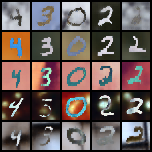

In [7]:
# For instance to visualize joint generation with the Visualization module

from multivae.metrics import Visualization, VisualizationConfig

vis_module = Visualization(model,
                           dataset,
                           output='./metrics',
                           sampler=sampler)

vis_module.unconditional_samples()

You can compare to unconditional samples generated from the prior:

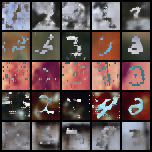

In [9]:
vis_module = Visualization(model,
                           dataset,
                           output='./metrics',
                           sampler=None # no sampler provided means it is the prior that is used.
                           )

vis_module.unconditional_samples()

You can also provide the sampler to the Coherences or the FIDs evaluator to compute metrics on joint generation when using that prior.

We provide here an example using the Coherences.

To compute coherences, you need to first download the PolyMNIST classifiers available at https://zenodo.org/record/4899160#.ZGeXzy0isf_
and place them in a `./clf/` folder at the same location of this notebook. 

Otherwise, untrained classifiers will be used. 

In [10]:
import torch
from torch import nn
import os

#### Define the classifiers architectures

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ClfImg(nn.Module):
    """
    MNIST image-to-digit classifier. Roughly based on the encoder from:
    https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb
    """

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(  # input shape (3, 28, 28)
            nn.Conv2d(3, 10, kernel_size=4, stride=2, padding=1),  # -> (10, 14, 14)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=4, stride=2, padding=1),  # -> (20, 7, 7)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            Flatten(),  # -> (980)
            nn.Linear(980, 128),  # -> (128)
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10),  # -> (10)
        )

    def forward(self, x):
        h = self.encoder(x)
        # return F.log_softmax(h, dim=-1)
        return h


def load_mmnist_classifiers(data_path="your_data_path", device="cuda"):
    '''
    Function to load the classifiers state_dict.
    '''
    clfs = {}
    for i in range(5):
        fp = os.path.join(data_path,"pretrained_img_to_digit_clf_m" + str(i))
        model_clf = ClfImg()
        
        if os.path.exists(fp):
            model_clf.load_state_dict(torch.load(fp, map_location=torch.device(device)))
        else :
            print('Careful, untrained classifiers are used!')
            
        model_clf = model_clf.to(device)
        clfs["m%d" % i] = model_clf
    for m, clf in clfs.items():
        if clf is None:
            raise ValueError("Classifier is 'None' for modality %s" % str(i))
    return clfs



In [13]:
clfs = load_mmnist_classifiers('/home/asenella/scratch/data/clf', device = 'cpu') # give the path to your classifiers here.
# is a dictionary with one network per modality

In [14]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(batch_size=128,
                                             nb_samples_for_joint=100,
                                            #  wandb_path='your_wand_path'
                                             )

coherences_module = CoherenceEvaluator(model=model, 
                                       classifiers=clfs,
                                       output='./metrics',
                                       test_dataset=dataset,
                                       sampler=sampler # give the trained sampler as input here!
                                       )

coherences_module.joint_coherence()
coherences_module.finish()

Joint coherence with sampler GaussianMixtureSampler: 0.694100022315979
